In [1]:
#Recap of important concepts:
#In SQLAlchemy, a "Base" refers to a declarative base class that serves as a foundation for defining your database tables as Python classes. When you create a class that inherits from this Base class, SQLAlchemy can automatically map the class to a corresponding table in the database.

#Here's a brief overview of how it works:

#Declarative Base: You create a declarative base using declarative_base() from SQLAlchemy. This function returns a base class that maintains a catalog of classes and tables relative to that base.

#Defining Classes: When you define a class that inherits from this Base, you can specify the table name and columns as class attributes. Each attribute corresponds to a column in the database table.

#Creating Tables: Once you have defined your classes, you can create the corresponding tables in the database by calling Base.metadata.create_all(engine), where engine is your database connection.

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, and_, text, inspect, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

# reflect the tables
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# View all of the classes that automap found
#---------------------------------------------------

#Option 1:
reflected_classes=Base.classes.keys()
for class_name in reflected_classes:
    print(class_name)

#Option 2:
# Create the inspector and connect it to the engine
inspector=inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

measurement
station


['measurement', 'station']

In [8]:
# Save references to each table. Each table is a class
measurement=Base.classes.measurement
station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session=Session(engine)


# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
#---------------------------------------------------------------------------

#See which columns Measurement and Station tables have:
columns_measurement = inspector.get_columns("measurement")
for column in columns_measurement:
    print(column["name"], column["type"])

columns_station= inspector.get_columns("station")
for column in columns_station:
    print(column["name"], column["type"])

#See how the data looks in Measurement table:
with engine.connect() as conn:
    print(conn.execute(text('SELECT * FROM measurement LIMIT 5')).fetchall())

#See how data looks in Station table:
with engine.connect() as conn:
    print(conn.execute(text('SELECT * FROM station LIMIT 5')).fetchall())

# Count total dates in Measurement Table:
session.query(func.count(measurement.date)).all()

# Oldest Date
earliest_date=session.query(measurement.date).order_by(measurement.date).first()
print(earliest_date)

# Most Recent Date****
latest_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
print(latest_date)



#Homework Notes (please disregard)
#----------------------------------------------------------------------------------------------
#The earliest date (oldest date) is calculated:
#session.query(measurement.date).order_by(measurement.date).first()

#Explanation:
#session.query(measurement.date) selects the date column from the measurement table.
#.order_by(measurement.date) orders the results by the date column in ascending order.
#.first() retrieves the first record from the ordered results, which will be the earliest date.


#I can also calculate the most recent way as:
#session.execute(text("SELECT MAX(date) FROM measurement")).scalar()
#print(result)

#Explanation:
#session.execute(...): This part of the code is using the SQLAlchemy session object to execute a raw SQL query.
#The SQL query being executed is "SELECT MIN(date) FROM measurement", which is a standard SQL statement that retrieves the minimum (earliest) date
#.scalar() retrieves the single value (the latest date) from the query result.


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
[(1, 'USC00519397', '2010-01-01', 0.08, 65.0), (2, 'USC00519397', '2010-01-02', 0.0, 63.0), (3, 'USC00519397', '2010-01-03', 0.0, 74.0), (4, 'USC00519397', '2010-01-04', 0.0, 76.0), (5, 'USC00519397', '2010-01-06', None, 73.0)]
[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]
('2010-01-01',)
('2017-08-23',)


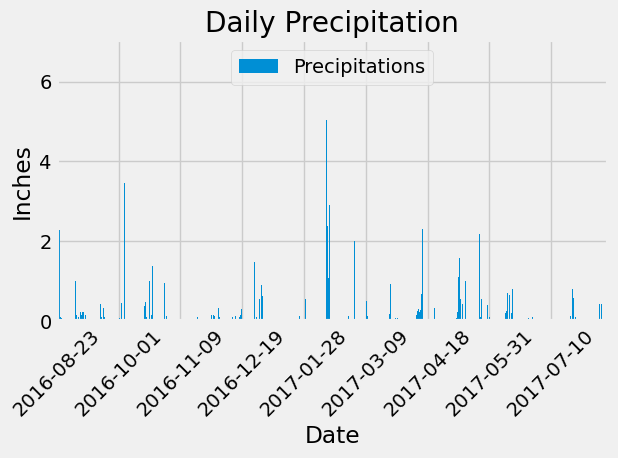

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set: 
# Perform a query to retrieve the data and precipitation scores
#----------------------------------------------------------------

#Store in one variable the table columns "date" and "precipitations"
select_info = [measurement.date, measurement.prcp]

#Query the new variable "select_inf"
precipitation_scores = session.query(*select_info).\
    filter(and_(measurement.date >= '2016-08-23', measurement.date <= '2017-08-23')).\
    order_by(measurement.date).all()

#Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_scores, columns=['Date', 'Precipitations'])
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])
   
# Sort the dataframe by date
sorted_df = df.sort_values(by='Date')
    
# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.set_index('Date', inplace=True)

n=250
sorted_df.plot.bar()
plt.xticks(ticks=range(0, len(sorted_df.index), n),labels=sorted_df.index[::n].strftime('%Y-%m-%d'), rotation=45)
plt.title('Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()


#Personal Explanation (please disregard)
#the query uses ".\"  at the end of a line in Python as a line continuation character. It allows you to split a long line of code into multiple lines for better readability. 
#This is particularly useful when you're chaining methods together, as in the case of the SQLAlchemy query.
#If you didn't use .\, the code would need to be written as a single line, which can be cumbersome:
#precipitation_scores = session.query(*select_info).filter(and_(measurement.date >= '2016-08-23', measurement.date <= '2017-08-23')).order_by(measurement.date).all()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Use Pandas to calculate the summary statistics for the precipitation data
count= sorted_df["Precipitations"].count()
mean= sorted_df["Precipitations"].mean()
median=sorted_df["Precipitations"].median()
std_dev= sorted_df["Precipitations"].std()
min_value= sorted_df["Precipitations"].min()
max_value= sorted_df["Precipitations"].max()
FirstQ= sorted_df["Precipitations"].quantile(0.25)
SecondQ= sorted_df["Precipitations"].quantile(0.50)
ThirdQ= sorted_df["Precipitations"].quantile(0.75)

precipitations_summary = pd.DataFrame({
    "count": [count],
    "mean": [mean],
    "median": [median],
    "std_dev": [std_dev],
    "min_value": [min_value],
    "25": [FirstQ],
    "50": [SecondQ],
    "75": [ThirdQ],
    "max_value": [max_value]
})
precipitations_summary = precipitations_summary.transpose()

# Display results
precipitations_summary


,0
count,2021.000000
mean,0.177279
median,0.020000
std_dev,0.461190
min_value,0.000000
25,0.000000
50,0.020000
75,0.130000
max_value,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station.station).count()
total_stations

9

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    measurement.station,
    func.count(measurement.station).label('station_count')
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

most_active_stations


#I cannot query by station because, the table only is a record of the sation's reference information. Measurement has the actual record of 
#how precipitations manifested at each of the stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
select_info_stations= session.query(measurement.station, measurement.station).all()

temperature_stats = session.query(
    func.min(measurement.tobs).label('min_temp'),
    func.max(measurement.tobs).label('max_temp'),
    func.avg(measurement.tobs).label('avg_temp')
).all()
temperature_stats

[(53.0, 87.0, 73.09795396419437)]

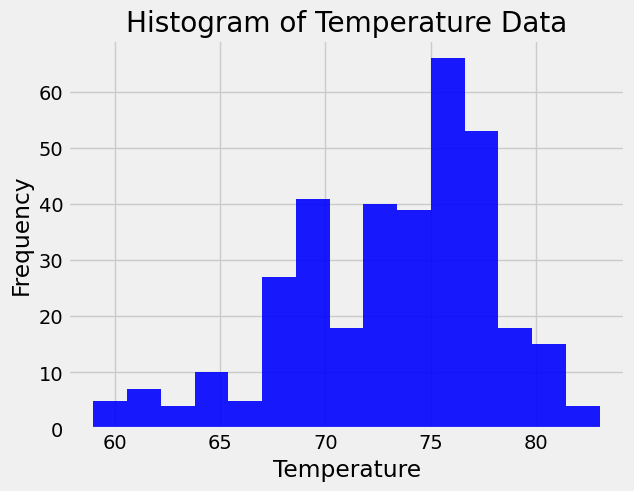

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#store the table columns in a variable
select_info2=[measurement.station, measurement.date, measurement.tobs]

#query the new variable
temperatures = session.query(*select_info2).\
    filter(and_(measurement.station=="USC00519281",measurement.date >= '2016-08-23', measurement.date <= '2017-08-23')).\
    order_by(measurement.tobs).all()

#Make a pandas data frame with the result
df2 = pd.DataFrame(temperatures, columns=["Station","Date","Temperature"])

#Plot the histogram
plt.hist(df2['Temperature'], bins=15, alpha=0.9, color='blue')  
plt.xlabel('Temperature') 
plt.ylabel('Frequency')  
plt.title('Histogram of Temperature Data') 
plt.show()  

# Close Session

In [21]:
# Close Session
session.close()